# Import Dependencies and Data

In [1]:
# import operating system 
import os

In [2]:
# import plotting dependencies
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt 
%matplotlib inline 

In [3]:
# import SciKitLearn, Keras, tensorflow, and image "rendering"
# cv2 is a Python library of bindings designed to solve computer vision problems
import cv2
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from concurrent import futures 
import threading 

In [4]:
# set random seed for reproducibility across different users 
np.random.seed(42)

In [5]:
tf.random.set_seed(42)
tf.__version__

'2.1.0'

# Load Data into DataFrames

In [13]:
base_dir = os.path.join('/cell_images')

In [14]:
valid_para_dir = os.path.join(base_dir,'Parasitized')
valid_healthy_dir = os.path.join(base_dir,'Uninfected')

In [15]:
# Validation data files 


# Find validation data, and sort into parasitized and uninfected using glob, a python module which will iterate 
# through all images (as png files) and create a list of files in a directory. Glob follows UNIX path expansion rules.

valid_para_files = glob.glob(valid_para_dir+'/*.png')


valid_healthy_files = glob.glob(valid_healthy_dir+'/*.png')

In [6]:
import os
import glob

base_dir = os.path.join('./cell_images/')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)

(13779, 13779)

In [16]:
# Length of files from validation set 
len(valid_para_files), len(valid_healthy_files)

(0, 0)

In [8]:
# Create validation data dataframe
valid_df = pd.DataFrame({'filename': valid_para_files + valid_healthy_files, 
           'label': ['Parasitized'] * len(valid_healthy_files) +
                    ['Uninfected'] * len(valid_healthy_files)}).sample(frac=1, random_state=42).reset_index(drop=True)
valid_df.head()

,filename,label


In [9]:
# first sanity check 
valid_df.info()
valid_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 2 columns):
filename    5512 non-null object
label       5512 non-null object
dtypes: object(2)
memory usage: 86.2+ KB


(5512, 2)

In [10]:
# Training data files 
base_dir = os.path.join('cell_images/train')
train_para_dir = os.path.join(base_dir,'Parasitized')
train_para_files = glob.glob(train_para_dir+'/*.png')
train_healthy_dir = os.path.join(base_dir,'Uninfected')
train_healthy_files = glob.glob(train_healthy_dir+'/*.png')

In [11]:
# Length of files from validation set 
len(train_para_files), len(train_healthy_files)

(11023, 11023)

In [12]:
# Create training data dataframe 
train_df = pd.DataFrame({'filename': train_para_files + train_healthy_files,
           'label': ['Parasitized'] * len(train_para_files) + 
                    ['Uninfected'] * len(train_healthy_files)}).sample(frac=1, random_state=42).reset_index(drop=True)

train_df.head()

,filename,label
0,cell_images/train/Parasitized/C128P89ThinF_IMG...,Parasitized
1,cell_images/train/Uninfected/C53P14thinF_IMG_2...,Uninfected
2,cell_images/train/Parasitized/C99P60ThinF_IMG_...,Parasitized
3,cell_images/train/Parasitized/C186P147NThinF_I...,Parasitized
4,cell_images/train/Parasitized/C59P20thinF_IMG_...,Parasitized


In [13]:
# second sanity check
train_df.info()
train_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22046 entries, 0 to 22045
Data columns (total 2 columns):
filename    22046 non-null object
label       22046 non-null object
dtypes: object(2)
memory usage: 344.5+ KB


(22046, 2)

In [14]:
# combine the two different dataframes from the training and validation data 
dataframes = [valid_df, train_df]
df = pd.concat(dataframes)

df.head()

,filename,label
0,cell_images/valid/Uninfected/C205ThinF_IMG_201...,Uninfected
1,cell_images/valid/Uninfected/C75P36_ThinF_IMG_...,Uninfected
2,cell_images/valid/Parasitized/ParasitizedC39P4...,Parasitized
3,cell_images/valid/Uninfected/C72P33_ThinF_IMG_...,Uninfected
4,cell_images/valid/Parasitized/ParasitizedC180P...,Parasitized


In [15]:
# third  sanity check because things often get weird up in here. 
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27558 entries, 0 to 22045
Data columns (total 2 columns):
filename    27558 non-null object
label       27558 non-null object
dtypes: object(2)
memory usage: 645.9+ KB


(27558, 2)

# Setting up Train-Test-Split

In [21]:
# train test split and get shape of files 
train_files, test_files, train_labels, test_labels = train_test_split(df['filename'].values,
                                                                      df['label'].values,
                                                                      test_size=0.3, random_state=42)

train_files, valid_files, train_labels, valid_labels = train_test_split(train_files,
                                                                    train_labels,
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, valid_files.shape, test_files.shape)
print('Training:', Counter(train_labels),'\nValidation:', Counter(valid_labels), '\nTesting:', Counter(test_labels))


(17361,) (1929,) (8268,)
Training: Counter({'Parasitized': 8682, 'Uninfected': 8679}) 
Validation: Counter({'Uninfected': 977, 'Parasitized': 952}) 
Testing: Counter({'Parasitized': 4145, 'Uninfected': 4123})


# Image Pre-Processing (This takes forever)


In [47]:
# this is to get the image shapes since they all might not be the same
def get_img_shape_parallel(index, image, total_images):
    if index % 5000 == 0 or index == (total_images - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name, index))
        
    return cv2.imread(image).shape
  
execute = futures.ThreadPoolExecutor(max_workers=None)
data_input = [(index, image, len(train_files)) for index, image in enumerate(train_files)]
print('Starting Image shape Computations...')

train_image_dimensions_map = execute.map(get_img_shape_parallel, 
                            [record[0] for record in data_input],
                            [record[1] for record in data_input],
                            [record[2] for record in data_input])
train_image_dimensions = list(train_image_dimensions_map)

print('Min Dimensions:', np.min(train_image_dimensions, axis=0)) 
print('Avg Dimensions:', np.mean(train_image_dimensions, axis=0))
print('Median Dimensions:', np.median(train_image_dimensions, axis=0))
print('Max Dimensions:', np.max(train_image_dimensions, axis=0))

Starting Image shape Computations...
ThreadPoolExecutor-2_0: working on img num: 0
ThreadPoolExecutor-2_19: working on img num: 5000
ThreadPoolExecutor-2_0: working on img num: 10000
ThreadPoolExecutor-2_27: working on img num: 15000
ThreadPoolExecutor-2_8: working on img num: 17360
Min Dimensions: [50 50  3]
Avg Dimensions: [50. 50.  3.]
Median Dimensions: [50. 50.  3.]
Max Dimensions: [50 50  3]


When you create a Thread, you pass it a function and a list containing the arguments to that function. In this case, you’re telling the Thread to run thread_function() and to pass it 1 as an argument.



# This takes five-ever 

In [22]:
# load images in the defined size so that they are consistent 

image_dimensions = img_dims = (50, 50)

def get_img_data_parallel(index, image, total_images):
    if index % 5000 == 0 or index == (total_images - 1):
        print('{}: working on image number: {}'.format(threading.current_thread().name, index))
    image = cv2.imread(image)
    image = cv2.resize(image, dsize= img_dims, 
                     interpolation=cv2.INTER_CUBIC)
    image = np.array(image, dtype=np.float32)
    return image

execute = futures.ThreadPoolExecutor(max_workers=None)

train_data_input = [(index, image, len(train_files)) for index, image in enumerate(train_files)]
valid_data_input = [(index, image, len(valid_files)) for index, image in enumerate(valid_files)]
test_data_input = [(index, image, len(test_files)) for index, image in enumerate(test_files)]

print('Loading Train Images...')
train_data_map = execute.map(get_img_data_parallel, 
                        [record[0] for record in train_data_input],
                        [record[1] for record in train_data_input],
                        [record[2] for record in train_data_input])
train_data = np.array(list(train_data_map))
print(f"Training Data Shape: {train_data.shape}")
print("-"*60)
print('Loading Validation Images...')
valid_data_map = execute.map(get_img_data_parallel, 
                        [record[0] for record in valid_data_input],
                        [record[1] for record in valid_data_input],
                        [record[2] for record in valid_data_input])
valid_data = np.array(list(valid_data_map))
print(f"Validation Data Shape: {valid_data.shape}")
print("-"*60)
print('Loading Test Images...')
test_data_map = execute.map(get_img_data_parallel, 
                        [record[0] for record in test_data_input],
                        [record[1] for record in test_data_input],
                        [record[2] for record in test_data_input])
test_data = np.array(list(test_data_map))
print(f"Testing Data Shape: {test_data.shape}")

Loading Train Images...
ThreadPoolExecutor-0_0: working on image number: 0
ThreadPoolExecutor-0_34: working on image number: 5000
ThreadPoolExecutor-0_36: working on image number: 10000
ThreadPoolExecutor-0_12: working on image number: 15000
ThreadPoolExecutor-0_19: working on image number: 17360
Training Data Shape: (17361, 50, 50, 3)
------------------------------------------------------------
Loading Validation Images...
ThreadPoolExecutor-0_10: working on image number: 0
ThreadPoolExecutor-0_31: working on image number: 1928
Validation Data Shape: (1929, 50, 50, 3)
------------------------------------------------------------
Loading Test Images...
ThreadPoolExecutor-0_18: working on image number: 0
ThreadPoolExecutor-0_18: working on image number: 5000
ThreadPoolExecutor-0_13: working on image number: 8267
Testing Data Shape: (8268, 50, 50, 3)


In [28]:
%matplotlib inline

['Uninfected' 'Uninfected' 'Parasitized' 'Uninfected' 'Parasitized'
 'Uninfected' 'Uninfected' 'Uninfected' 'Parasitized' 'Parasitized'
 'Parasitized' 'Parasitized' 'Uninfected' 'Parasitized' 'Uninfected'
 'Uninfected'] [1 1 0 1 0 1 1 1 0 0 0 0 1 0 1 1]


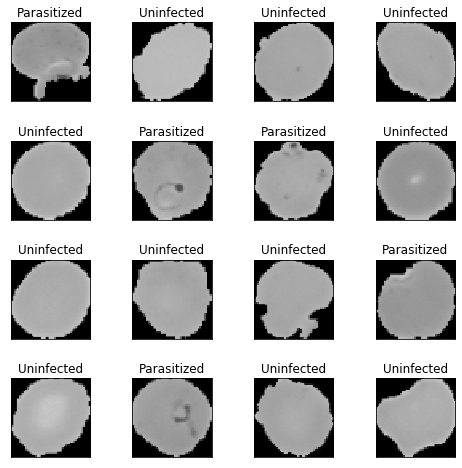

In [29]:
# use matplotlib to print pictures 
plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    
    n += 1 
    r = np.random.randint(42 , train_data.shape[0] , 1)
    
    plt.subplot(4 , 4 , n)
    
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    
    plt.imshow(train_data[r[0]]/255.)
    
    plt.title('{}'.format(train_labels[r[0]]))
    
    plt.xticks([]) , plt.yticks([])
    
print(train_labels[:16], enc_train_labels[:16])

['Parasitized' 'Uninfected' 'Uninfected' 'Parasitized' 'Parasitized'
 'Uninfected' 'Uninfected' 'Parasitized' 'Parasitized' 'Uninfected'
 'Uninfected' 'Uninfected' 'Uninfected' 'Parasitized' 'Parasitized'
 'Uninfected'] [0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 1]


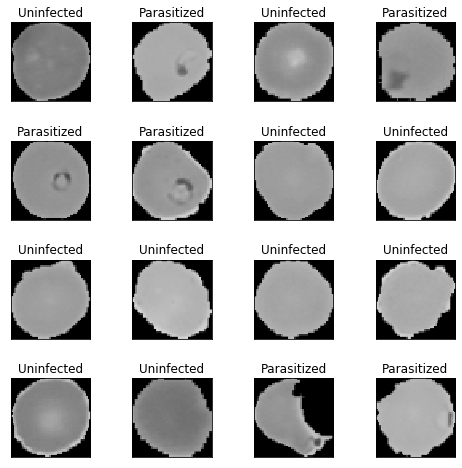

In [30]:
plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    
    n += 1 
    r = np.random.randint(42 , valid_data.shape[0] , 1)
    
    plt.subplot(4 , 4 , n)
    
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    
    plt.imshow(valid_data[r[0]]/255.)
    
    plt.title('{}'.format(valid_labels[r[0]]))
    
    plt.xticks([]) , plt.yticks([])
    
print(valid_labels[:16], enc_valid_labels[:16])

In [31]:
# configure data with labels and scaling
scaled_train_images = train_data / 255
scaled_valid_images = valid_data / 255

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_labels)
enc_train_labels = le.transform(train_labels)
enc_valid_labels= le.transform(valid_labels)

# Now for the Neural Network

In [32]:
# define image input shape and define inputs
input_shape = (50, 50, 3)
input = tf.keras.layers.Input(shape= input_shape)

In [53]:
# build model architecture 
conv_1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(input)
pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)

conv_2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(pool_1)
pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)

conv_3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(pool_2)
pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_3)

flat = tf.keras.layers.Flatten()(pool_3)

In [54]:
# build-in dropouts since this dataset is relatively small, over-fitting is likely. The drop out rate of 0.5 is chosen arbitrarily. 
hidden_1 = tf.keras.layers.Dense(512, activation='relu')(flat)
dropout_1 = tf.keras.layers.Dropout(rate=0.5)(hidden_1)

hidden_2 = tf.keras.layers.Dense(512, activation='relu')(dropout_1)
dropout_2 = tf.keras.layers.Dropout(rate=0.5)(hidden_2)

output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_2)

Example Architecture: Overview. We will go into more details below, but a simple ConvNet for CIFAR-10 classification could have the architecture [INPUT - CONV - RELU - POOL - FC]. In more detail:

INPUT [32x32x3] will hold the raw pixel values of the image, in this case an image of width 32, height 32, and with three color channels R,G,B.

CONV layer will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. This may result in volume such as [32x32x12] if we decided to use 12 filters.

RELU layer will apply an elementwise activation function, such as the max(0,x)
m
a
x
(
0
,
x
)
 thresholding at zero. This leaves the size of the volume unchanged ([32x32x12]).
 
POOL layer will perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as [16x16x12].
http://cs231n.github.io/convolutional-networks/

so-called hidden layer because its values are not observed in the training set.
https://towardsdatascience.com/understanding-neural-networks-from-neuron-to-rnn-cnn-and-deep-learning-cd88e90e0a90

prevent overfitting Simply put, dropout refers to ignoring units (i.e. neurons) during the training phase of certain set of neurons which is chosen at random. By “ignoring”, I mean these units are not considered during a particular forward or backward pass.
More technically, At each training stage, individual nodes are either dropped out of the net with probability 1-p or kept with probability p, so that a reduced network is left; incoming and outgoing edges to a dropped-out node are also removed.
https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5

In [55]:
my_model = tf.keras.Model(inputs = input, outputs = output)

In [56]:
my_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
my_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0     

In [40]:
# import datetime
logdir = os.path.join('../tensorboard_logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [60]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001)

callbacks = [reduce_lr, tensorboard_callback]

In [61]:
# Definitions for later 
Batch_Size = 64
# Number of samples per gradient update
number_classes = 2 
# total number of classes
Epics = 25
# "EPOCHS" spelled wrong; an arbitrary cutoff, generally defined as “one pass over the entire dataset”, 
# used to separate training into distinct phases
Validation = (scaled_valid_images, enc_valid_labels)

In [62]:
history = my_model.fit(x=scaled_train_images, 
                    y=enc_train_labels, 
                    batch_size=Batch_Size, 
                    epochs=Epics, 
                    validation_data=Validation,
                    callbacks=callbacks, 
                    verbose=1)

Train on 17361 samples, validate on 1929 samples
Epoch 1/25
17361/17361 [==============================] - 31s 2ms/sample - loss: 0.5050 - accuracy: 0.7211 - val_loss: 0.1984 - val_accuracy: 0.9404
Epoch 2/25
17361/17361 [==============================] - 28s 2ms/sample - loss: 0.1836 - accuracy: 0.9347 - val_loss: 0.1523 - val_accuracy: 0.9518
Epoch 3/25
17361/17361 [==============================] - 29s 2ms/sample - loss: 0.1557 - accuracy: 0.9445 - val_loss: 0.1490 - val_accuracy: 0.9518
Epoch 4/25
17361/17361 [==============================] - 30s 2ms/sample - loss: 0.1454 - accuracy: 0.9472 - val_loss: 0.1494 - val_accuracy: 0.9492
Epoch 5/25
17361/17361 [==============================] - 29s 2ms/sample - loss: 0.1329 - accuracy: 0.9526 - val_loss: 0.1375 - val_accuracy: 0.9539
Epoch 6/25
17361/17361 [==============================] - 29s 2ms/sample - loss: 0.1251 - accuracy: 0.9546 - val_loss: 0.1401 - val_accuracy: 0.9549
Epoch 7/25
17361/17361 [==============================] -

In [63]:
# definitions for the graphs below 

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))

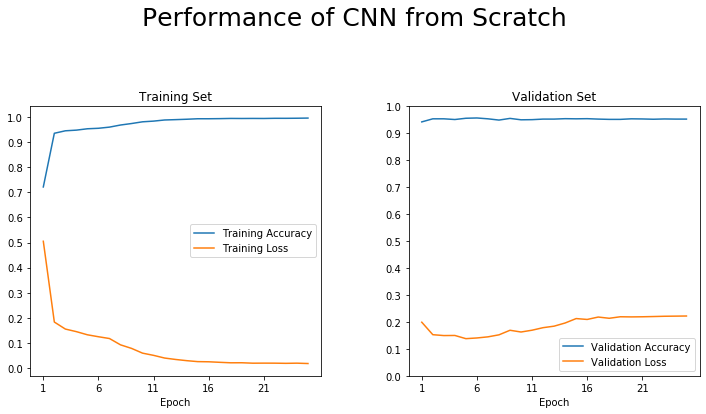

In [64]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
t = f.suptitle('Performance of CNN from Scratch', fontsize=25)
f.subplots_adjust(top=0.75, wspace=0.3)

# figure 1
ax1.plot(epoch_list, history.history['accuracy'], label='Training Accuracy')
ax1.plot(epoch_list, history.history['loss'], label='Training Loss')

ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_yticks(np.arange(0, 1.1, step=0.1))
ax1.set_xlabel('Epoch')
ax1.set_title('Training Set')

l1 = ax1.legend(loc="best")

# figure 2
ax2.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')

ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_yticks(np.arange(0, 1.1, step=0.1))
ax2.set_xlabel('Epoch')
ax2.set_title('Validation Set')

l2 = ax2.legend(loc="best")

# VGG-19


In [66]:
type(my_model)
my_model.save("my_cnn.h5")

In [67]:

from tensorflow.keras.layers import Input, Embedding, Activation, Flatten, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.models import Model

In [68]:
test = tf.keras.models.load_model('my_cnn.h5')

In [69]:
test.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0     

In [37]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=input_shape)
vgg.trainable = False
# Freeze the layers
for layer in vgg.layers:
    layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [38]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", 
      sum([1 for l in model.layers if l.trainable]))


Total Layers: 28
Total trainable layers: 6


In [44]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, 
#                                              mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduce_lr, tensorboard_callback]

history = model.fit(x=scaled_train_images, y=enc_train_labels, 
                    batch_size=Batch_Size,
                    epochs=Epics, 
                    validation_data=(scaled_valid_images, enc_valid_labels), 
                    callbacks=callbacks,
                    verbose=1)

Train on 17361 samples, validate on 1929 samples
Epoch 1/25
17361/17361 [==============================] - 137s 8ms/sample - loss: 0.4770 - accuracy: 0.7716 - val_loss: 0.3542 - val_accuracy: 0.8414
Epoch 2/25
17361/17361 [==============================] - 140s 8ms/sample - loss: 0.3738 - accuracy: 0.8332 - val_loss: 0.3261 - val_accuracy: 0.8471
Epoch 3/25
17361/17361 [==============================] - 136s 8ms/sample - loss: 0.3500 - accuracy: 0.8419 - val_loss: 0.3280 - val_accuracy: 0.8517
Epoch 4/25
17361/17361 [==============================] - 136s 8ms/sample - loss: 0.3329 - accuracy: 0.8515 - val_loss: 0.2988 - val_accuracy: 0.8678
Epoch 5/25
17361/17361 [==============================] - 135s 8ms/sample - loss: 0.3210 - accuracy: 0.8580 - val_loss: 0.3032 - val_accuracy: 0.8647
Epoch 6/25
17361/17361 [==============================] - 136s 8ms/sample - loss: 0.3111 - accuracy: 0.8627 - val_loss: 0.2861 - val_accuracy: 0.8777
Epoch 7/25
17361/17361 [===========================

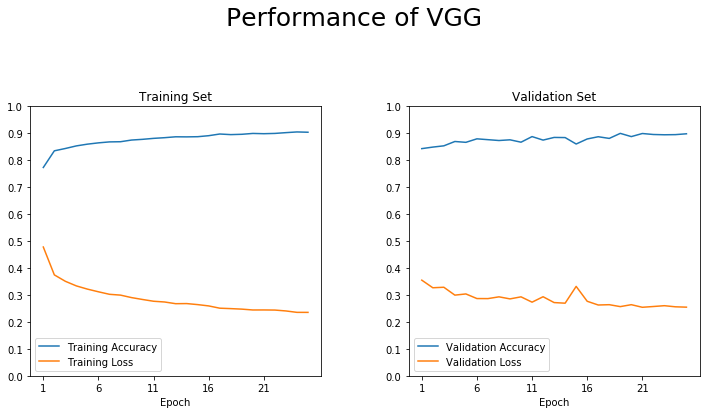

In [46]:
max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
t = f.suptitle('Performance of VGG', fontsize=25)
f.subplots_adjust(top=0.75, wspace=0.3)

# figure 1
ax1.plot(epoch_list, history.history['accuracy'], label='Training Accuracy')
ax1.plot(epoch_list, history.history['loss'], label='Training Loss')

ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_yticks(np.arange(0, 1.1, step=0.1))
ax1.set_xlabel('Epoch')
ax1.set_title('Training Set')

l1 = ax1.legend(loc="best")

# figure 2
ax2.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')

ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_yticks(np.arange(0, 1.1, step=0.1))
ax2.set_xlabel('Epoch')
ax2.set_title('Validation Set')

l2 = ax2.legend(loc="best")

In [42]:
# Definitions for later 
Batch_Size = 64
# Number of samples per gradient update
number_classes = 2 
# total number of classes
Epics = 25
# "EPOCHS" spelled wrong; an arbitrary cutoff, generally defined as “one pass over the entire dataset”, 
# used to separate training into distinct phases
Validation = (scaled_valid_images, enc_valid_labels)

# And Another One *DJ Khalid Voice* (Just kidding it's just VGG19)

we will fine-tune the weights of the layers in the last two blocks of our pre-trained VGG-19 model. We will also introduce the concept of image augmentation. The idea behind image augmentation is exactly as the name sounds. We load in existing images from our training dataset and apply some image transformation operations to them, such as rotation, shearing, translation, zooming, and so on, to produce new, altered versions of existing images. Due to these random transformations, we don't get the same images each time. We will leverage an excellent utility called ImageDataGenerator in tf.keras that can help build image augmentors.

https://nbviewer.jupyter.org/github/dipanjanS/data_science_for_all/tree/master/os_malaria_detection/

In [94]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05, 
                                                                rotation_range=25,
                                                                width_shift_range=0.05, 
                                                                height_shift_range=0.05, 
                                                                shear_range=0.05, horizontal_flip=True, 
                                                                fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Labels: ['Uninfected', 'Uninfected', 'Uninfected', 'Uninfected', 'Uninfected', 'Uninfected']


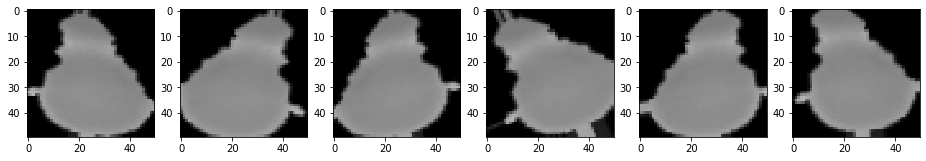

In [95]:
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,6)]
fig, ax = plt.subplots(1,6, figsize=(16, 8))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,6)]

In [96]:
Batch_Size = 64
number_classes = 2 
New_Epics = 5
Validation = (scaled_valid_images, enc_valid_labels)
input_shape = (50, 50, 3)
input = tf.keras.layers.Input(shape= input_shape)

In [97]:
train_generator = train_datagen.flow(train_data, enc_train_labels, batch_size=Batch_Size, shuffle=True)
val_generator = val_datagen.flow(valid_data, enc_valid_labels, batch_size=Batch_Size, shuffle=False)

In [98]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=input_shape)
# Freeze the layers
vgg.trainable = True

set_trainable = False
for layer in vgg.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.5)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.5)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])

print("Total Layers:", len(model.layers))
print("Total trainable layers:", sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 16


In [99]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001)

callbacks = [reduce_lr, tensorboard_callback]

train_steps_per_epoch = train_generator.n // train_generator.batch_size

val_steps_per_epoch = val_generator.n // val_generator.batch_size

In [101]:
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, 
                              epochs=New_Epics,
                              validation_data=val_generator, 
                              validation_steps=val_steps_per_epoch, 
                              verbose=1)


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 271 steps, validate for 30 steps
Epoch 1/5
271/271 [==============================] - 378s 1s/step - loss: 0.3960 - accuracy: 0.8152 - val_loss: 0.2922 - val_accuracy: 0.8786
Epoch 2/5
271/271 [==============================] - 383s 1s/step - loss: 0.2582 - accuracy: 0.8933 - val_loss: 0.2025 - val_accuracy: 0.9198
Epoch 3/5
271/271 [==============================] - 379s 1s/step - loss: 0.2185 - accuracy: 0.9107 - val_loss: 0.1545 - val_accuracy: 0.9401
Epoch 4/5
271/271 [==============================] - 372s 1s/step - loss: 0.1958 - accuracy: 0.9222 - val_loss: 0.1856 - val_accuracy: 0.9260
Epoch 5/5
271/271 [==============================] - 383s 1s/step - loss: 0.1873 - accuracy: 0.9278 - val_loss: 0.1463 - val_accuracy: 0.9448


In [104]:
# definitions for the graphs below 
max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))

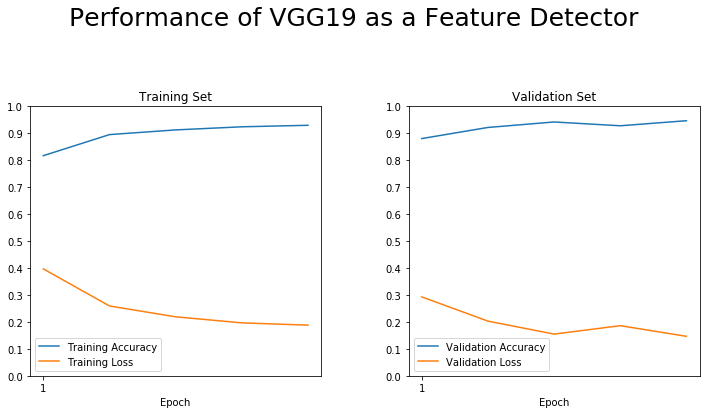

In [105]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
t = f.suptitle('Performance of VGG19 as a Feature Detector', fontsize=25)
f.subplots_adjust(top=0.75, wspace=0.3)

# figure 1
ax1.plot(epoch_list, history.history['accuracy'], label='Training Accuracy')
ax1.plot(epoch_list, history.history['loss'], label='Training Loss')

ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_yticks(np.arange(0, 1.1, step=0.1))
ax1.set_xlabel('Epoch')
ax1.set_title('Training Set')

l1 = ax1.legend(loc="best")

# figure 2
ax2.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')

ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_yticks(np.arange(0, 1.1, step=0.1))
ax2.set_xlabel('Epoch')
ax2.set_title('Validation Set')

l2 = ax2.legend(loc="best")

In [106]:
model.save("my_vgg.h5")

In [107]:
test_2 = tf.keras.models.load_model('my_vgg.h5')

In [108]:
test_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

# Comparing Models 

In [189]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

In [190]:
# load and scale testing images
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

((8268, 50, 50, 3), (8268,))

In [191]:
# load saved models
basic_cnn = load_model('my_cnn.h5')
img_aug_cnn = load_model('my_vgg.h5')

In [192]:
# Make Predictions on Test Data
basic_cnn_preds = basic_cnn.predict(test_imgs_scaled, batch_size=512)
vgg_ft_preds = img_aug_cnn.predict(test_imgs_scaled, batch_size=512)

In [193]:
basic_cnn_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in basic_cnn_preds.ravel()])

In [200]:
# Found this cool python script which defines metrics
import model_evaluation_utils as meu

In [201]:
basic_cnn_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=basic_cnn_pred_labels)

vgg_ft_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=vgg_ft_preds_labels)

In [202]:
comparison_df = pd.DataFrame([basic_cnn_metrics, vgg_ft_metrics])
comparison_df

,Accuracy,F1 Score:,Precision:,Recall
0,0.9418,0.9418,0.9421,0.9418
1,0.9367,0.9367,0.9380,0.9367
